In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parallel Processing and C++ 

**1**. (25 points) Accelerating network bound procedures.

- Print the names of the first 5 PNG images on the URL `http://people.duke.edu/~ccc14/misc/`. (10 points)
- Write a function that uses a for loop to download all images and time how long it takes (5 points)
- Write a function that uses `concurrent.futures` and a thread pool to download all images and time how long it takes (5 points)
- Write a function that uses `multiprocessing` and a process pool to download all images and time how long it takes (5 points)

In [3]:
import requests
from bs4 import BeautifulSoup

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + node.get('href') for node in soup.find_all('a') 
            if node.get('href').endswith(ext)]

site = 'http://people.duke.edu/~ccc14/misc/'
ext = 'png'
for i, file in enumerate(listFD(site, ext)):
    if i == 5:
        break
    print(file)

http://people.duke.edu/~ccc14/misc/250px-002Ivysaur.png
http://people.duke.edu/~ccc14/misc/250px-003Venusaur.png
http://people.duke.edu/~ccc14/misc/250px-004Charmander.png
http://people.duke.edu/~ccc14/misc/250px-005Charmeleon.png
http://people.duke.edu/~ccc14/misc/250px-006Charizard.png


In [4]:
def download_one(url, path):
    r = requests.get(url, stream=True)
    img = r.raw.read()
    with open(path, 'wb') as f:
        f.write(img) 

In [5]:
%%time

for url in listFD(site, ext):
    filename = os.path.split(url)[-1]
    download_one(url, filename)

CPU times: user 300 ms, sys: 56 ms, total: 356 ms
Wall time: 8.38 s


In [6]:
%%time

from concurrent.futures import ThreadPoolExecutor

args = [(url, os.path.split(url)[-1]) 
        for url in listFD(site, ext)]
with ThreadPoolExecutor(max_workers=4) as pool:
    pool.map(lambda x: download_one(x[0], x[1]), args)

CPU times: user 264 ms, sys: 84 ms, total: 348 ms
Wall time: 2.19 s


In [7]:
%%time

from multiprocessing import Pool

args = [(url, os.path.split(url)[-1]) 
        for url in listFD(site, ext)]
with Pool(processes=4) as pool:
    pool.starmap(download_one, args)

CPU times: user 56 ms, sys: 8 ms, total: 64 ms
Wall time: 2.5 s


**2**. (25 points) Accelerating CPU bound procedures

- Use the insanely slow [Buffon's needle](https://en.wikipedia.org/wiki/Buffon's_needle) algorithm to estimate $\pi$.  Suppose the needle is of length 1, and the lines are also 1 unit apart.  Write a function to simulate the dropping of a pin with a random position and random angle, and return 0 if it does not cross a line and 1 if it does. Since the problem is periodic, you can assume that the bottom of the pin falls within (0, 1) and check if it crosses the line `y=0` or `y=1`. (10 points)
- Calculate pi from dropping `n=10^6` pins and time it (10 points)
- Use `concurrent.futures` and a process pool to parallelize  your solution and time it.

In [8]:
n = 100
p = 10
xs = np.random.random((n, p))

In [9]:
# This is the only version necessary. 
# The numba and numpy versions are just for education.

def buffon():
    """Simulate dropping of one needle."""
    center = np.random.random()
    angle = 2*np.pi*np.random.random()
    offset = 0.5 * np.sin(angle)
    if (center + offset > 1) or (center - offset < 0):
        return 1
    else:
        return 0

def buffon_python(n):
    """Calcualte π using Buffon's needle method."""
    crosses = 0
    for i in range(n):
        crosses += buffon()
    return n/crosses   

In [10]:
def buffon_numpy(n):
    """Calcualte π using Buffon's needle method."""
    centers = np.random.uniform(0, 1, n)
    angles = np.random.uniform(0, 2*np.pi, n)
    offset = 0.5 * np.sin(angles)
    crosses = np.sum((centers + offset > 1) | (centers - offset < 0))
    return n/crosses    

In [11]:
import numba

@numba.jit(nopython=True)
def buffon_():
    """Simulate dropping of one needle."""
    center = np.random.random()
    angle = 2*np.pi*np.random.random()
    offset = 0.5 * np.sin(angle)
    if (center + offset > 1) or (center - offset < 0):
        return 1
    else:
        return 0

@numba.jit(nopython=True)
def buffon_numba(n):
    """Calcualte π using Buffon's needle method."""
    crosses = 0
    for i in range(n):
        crosses += buffon_()
    return n/crosses   

In [12]:
%%time
n = int(1e6)
print(buffon_python(n))

3.1473956874384292
CPU times: user 2.57 s, sys: 8 ms, total: 2.58 s
Wall time: 2.61 s


In [13]:
# force JIT compilation before timing
print(buffon_numba(100))

3.0303030303030303


In [14]:
%%time
n = int(1e6)
print(buffon_numba(n))

3.141058662411579
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 89.7 ms


In [15]:
%%time
n = int(1e6)
print(buffon_numpy(n))

3.13766833591
CPU times: user 80 ms, sys: 12 ms, total: 92 ms
Wall time: 99.7 ms


In [16]:
from concurrent.futures import ProcessPoolExecutor

In [17]:
def buffon_pool(n, f, k):
    with ProcessPoolExecutor(max_workers=k) as pool:
        return np.mean(list(pool.map(f, [n//k] * k)))

In [18]:
%%time
n = int(1e6)
k = 4
print([n/k] * k)
print(buffon_pool(n, buffon_python, 4))

[250000.0, 250000.0, 250000.0, 250000.0]
3.14580161317
CPU times: user 0 ns, sys: 20 ms, total: 20 ms
Wall time: 938 ms


**3**. (25 points) Use C++ to

- Generate 10 $x$-coordinates linearly spaced between 10 and 15
- Generate 10 random $y$-values as $y = 3x^2 − 7x + 2 + \epsilon$ where $\epsilon∼10N(0,1)$
- Find the norm of $x$ and $y$ considered as length 10-vectors
- Find the Euclidean distance between $x$ and $y$
- Solve the linear system to find a quadratic fit for this data

You may wish to use `armadillo` or `eigen` to solve this exercise.

In [19]:
%%file hw6_ex3.cpp
#include <iostream>
#include <fstream>
#include <armadillo>
using std::cout;
using std::ofstream;

int main()
{
    using namespace arma;

    vec x = linspace<vec>(10.0,15.0,10);
    vec eps = 10*randn<vec>(10);
    vec y = 3*x%x - 7*x + 2 + eps;

    cout << "x:\n" << x << "\n";
    cout << "y:\n" << y << "\n";

    cout << "Lenght of x is: " << norm(x) << "\n";
    cout << "Lenght of y is: " << norm(y) << "\n";

    cout << "Distance(x, y) is: " << norm(x -y) << "\n";

    cout << "Correlation(x, y) is: " << cor(x, y) << "\n";

    mat A = join_rows(ones<vec>(10), x);
    A = join_rows(A, x%x);
    cout << "A:\n" << A << "\n";

    vec b = solve(A, y);
    cout << "b:\n" << b << "\n";

    ofstream fout1("x.txt");
    x.print(fout1);
    ofstream fout2("y.txt");
    y.print(fout2);
    ofstream fout3("b.txt");
    b.print(fout3);
}

Overwriting hw6_ex3.cpp


In [20]:
%%bash
g++ -std=c++11 hw6_ex3.cpp -o hw6_ex3 -larmadillo
./hw6_ex3

x:
   10.0000
   10.5556
   11.1111
   11.6667
   12.2222
   12.7778
   13.3333
   13.8889
   14.4444
   15.0000

y:
   2.2513e+02
   2.7027e+02
   2.9660e+02
   3.2962e+02
   3.6404e+02
   3.9959e+02
   4.2064e+02
   4.8632e+02
   5.3136e+02
   5.5517e+02

Lenght of x is: 39.8493
Lenght of y is: 1271.44
Distance(x, y) is: 1232
Correlation(x, y) is:    0.9956

A:
   1.0000e+00   1.0000e+01   1.0000e+02
   1.0000e+00   1.0556e+01   1.1142e+02
   1.0000e+00   1.1111e+01   1.2346e+02
   1.0000e+00   1.1667e+01   1.3611e+02
   1.0000e+00   1.2222e+01   1.4938e+02
   1.0000e+00   1.2778e+01   1.6327e+02
   1.0000e+00   1.3333e+01   1.7778e+02
   1.0000e+00   1.3889e+01   1.9290e+02
   1.0000e+00   1.4444e+01   2.0864e+02
   1.0000e+00   1.5000e+01   2.2500e+02

b:
  -66.5216
    5.6618
    2.4158



**4**. (25 points) **4**. Write a C++ function that uses the `eigen` library to solve the least squares linear problem

$$
\beta = (X^TX)^{-1}X^Ty
$$

for a matrix $X$ and vector $y$ and returns the vector of coefficients $\beta$. Wrap the function for use in Python and call it like so

```
beta <- least_squares(X, y)
```

where $X$ and $y$ are given below. 

Wrap the function so that it can be called from Python and compare with the `np.linalg.lstsq` solution shown.

In [21]:
n = 10
x = np.linspace(0, 10, n)
y = 3*x**2 - 7*x + 2 + np.random.normal(0, 10, n)
X = np.c_[np.ones(n), x, x**2]

In [22]:
beta = np.linalg.lstsq(X, y)[0]

In [23]:
beta

array([ 10.86797946,  -7.88477088,   2.84496434])

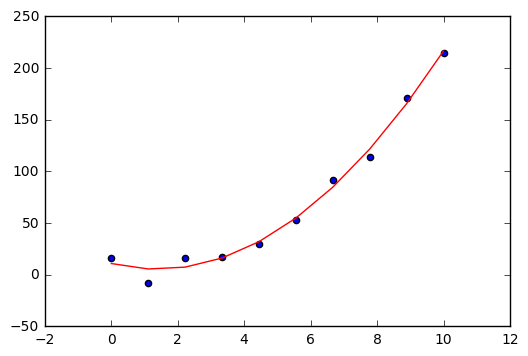

In [24]:
plt.scatter(x, y)
plt.plot(x, X @ beta, 'red')
pass

In [25]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['./eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

#include <Eigen/LU>

namespace py = pybind11;

// Note: This direct translation is not the most stable or efficient way to solve this
Eigen::VectorXd least_squares(Eigen::MatrixXd X, Eigen::VectorXd y) {
    auto XtX = X.transpose() * X;
    auto Xty = X.transpose() * y;
    return XtX.inverse() * Xty;
}

PYBIND11_PLUGIN(wrap) {
    pybind11::module m("wrap", "auto-compiled c++ extension");
    m.def("least_squares", &least_squares);
    return m.ptr();
}

Overwriting wrap.cpp


In [26]:
n = 10
x = np.linspace(0, 10, n)
y = 3*x**2 - 7*x + 2 + np.random.normal(0, 10, n)
X = np.c_[np.ones(n), x, x**2]

In [27]:
import cppimport

m = cppimport.imp("wrap")
beta = m.least_squares(X, y)
beta

array([ 10.25894816, -10.33297822,   3.27286481])

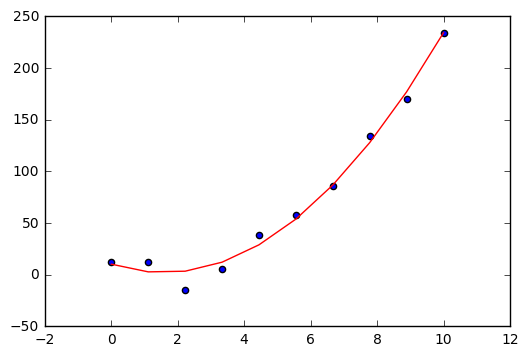

In [28]:
plt.scatter(x, y)
plt.plot(x, X @ beta, 'red')
pass